In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import random
from copy import deepcopy

def describe_fit( result):
    formula = result[ "formula"]
    print "regression: ", formula
    print "n: ", result[ "n"]
    print "----------"
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print variable.strip() + ": ", coefficient
    print "----------"
    print "sigma", result[ "sigma"]
    print "R^2", result[ "r^2"]
    
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

def holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor):
    this_factor = factor + delta * (1.0 - alpha) * error / ( level + trend)
    this_trend = trend + (gamma * alpha * error) / factor
    this_level = level + trend + (alpha * error) / factor
    return (this_factor, this_trend, this_level)

def holt_winters_forecast(level_0, trend_0, alpha, gamma, delta, actual, seasonality):
    n = len(actual)
    trend, level, factor = trend_0, level_0, seasonality[0]
    factors = []
    trends = []
    levels = []
    forecasts = []
    
    for i in xrange(0, n):
        if i < 12:
            factor = seasonality[i]
        else:
            factor = factors[i - 12]

        forecast = (level + trend) * factor
        forecasts.append(forecast)
        
        error = actual[i] - forecast

        factor, trend, level = holt_winters_one_step(alpha, gamma, delta, level, trend, error, factor)
        
        factors.append(factor)
        trends.append(trend)
        levels.append(level)
        
        #print forecast, error, level, trend, factor

    return (pd.Series(forecasts), pd.Series(levels), pd.Series(trends), pd.Series(factors))

# Module 12 Lab - Time Series

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In this Module, we talked about doing forecasting. Whether it was averaging past values to do level forecasting, simple exponential smoothing, Holt's trend corrected exponential smoothing or, the Big Kahuna, Holt-Winters.

As we remarked in the lectures, time series are generally thought be composed of four parts:

1. level
2. trend
3. seasonality
4. "other" or sometimes just $\epsilon$

What you should do in this Lab is generate Time Series with various levels, trends, and seasonality, spice them up with different degrees of "other" and see if if you can use Holt-Winter to recover your parameters.

The first thing you should do is pick a cycle. If you pick months, then generate several years worth of data. If you pick weeks, you should probably also generate a few years of data. For days, you might generate a few months of data or even a few years a layer interesting seasonality affects. Do interesting things happen on Fridays? The first and fifteenth of the month? You can even do hours over the course of several weeks. 

Try out a few different variations.

Then...generate a dataset for your lab discussion group. They'll need some basic insights into the data (is it monthly, for example).

In [3]:
# Read in easy.csv
df = pd.read_csv('easy.csv', header=0, usecols=[1,2])

In [4]:
df

,month,temperature
0,1,36.205000
1,2,36.065196
2,3,42.502227
3,4,51.192617
4,5,63.210340
5,6,68.757020
6,7,77.201840
7,8,71.526510
8,9,66.641820
9,10,58.468595


Following the strategy listed in the lecture notebook, we need to: <br>
-Identify the seasonality<br>
-Remove the seasonality from the historical data.<br>
-Identify the level and trend on the deseasonalized data.<br>

To identify the seasonality, we need to calculate a 2 x 12 moving average:

First, let's calculate the moving average offset by -6 and +5:

In [5]:
ma_temp = pd.rolling_mean(df["temperature"], window=12, center=True)
ma_temp

/Users/moose/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=True).mean()
  if __name__ == '__main__':


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     54.458920
7     54.638868
8     54.876077
9     55.162454
10    55.366142
11    55.587665
12    55.874720
13    56.261718
14    56.626286
15    56.857487
16    57.071082
17    57.233210
18    57.291986
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
Name: temperature, dtype: float64

Next, let's calclate the moving average with an offset of -5 and +6:

In [6]:
shifted_ma = []
for i in xrange( 0, len(df)):
    current = None
    if 5 < i < 19:
        current = df["temperature"][i-5:i+7].mean()
    shifted_ma.append(current)
shifted_ma_temp = pd.Series(shifted_ma)

print shifted_ma_temp

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     54.638868
7     54.876077
8     55.162454
9     55.366142
10    55.587665
11    55.874720
12    56.261718
13    56.626286
14    56.857487
15    57.071082
16    57.233210
17    57.291986
18    59.012678
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
dtype: float64


Next, let's avaerage our moving average estimates to create the 2x12 moving window:

In [7]:
smoothed_temp = (ma_temp + shifted_ma_temp) / 2.0
smoothed_temp[18] = None
smoothed_temp

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     54.548894
7     54.757473
8     55.019266
9     55.264298
10    55.476904
11    55.731192
12    56.068219
13    56.444002
14    56.741887
15    56.964284
16    57.152146
17    57.262598
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
dtype: float64

To get seasonality estimates, we can divide the original data with the moving average estimate:

In [8]:
seasonal_factor_estimate = df["temperature"] / smoothed_temp
seasonal_factor_estimate

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     1.415278
7     1.306242
8     1.211245
9     1.057981
10    0.784577
11    0.685612
12    0.684245
13    0.689386
14    0.809609
15    0.941588
16    1.152513
17    1.260887
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
dtype: float64

We have 24 seasonal estimates but we figure the seasonality of weather temperature will be one year so we only need 12 estimates:

In [9]:
initial_seasonal_factors = [
    seasonal_factor_estimate[[0, 12]].mean(),
    seasonal_factor_estimate[[1, 13]].mean(),
    seasonal_factor_estimate[[2, 14]].mean(),
    seasonal_factor_estimate[[3, 15]].mean(),
    seasonal_factor_estimate[[4, 16]].mean(),
    seasonal_factor_estimate[[5, 17]].mean(),
    seasonal_factor_estimate[[6, 18]].mean(),
    seasonal_factor_estimate[[7, 19]].mean(),
    seasonal_factor_estimate[[8, 20]].mean(),
    seasonal_factor_estimate[[9, 21]].mean(),
    seasonal_factor_estimate[[10, 22]].mean(),
    seasonal_factor_estimate[[11, 23]].mean()]
print initial_seasonal_factors
seasonal_factors = pd.Series(initial_seasonal_factors + deepcopy( initial_seasonal_factors) + deepcopy(initial_seasonal_factors))
df["seasonal"] = seasonal_factors

[0.6842446162475809, 0.6893860333256947, 0.8096091665359408, 0.9415877602474104, 1.152513376682917, 1.260887294887345, 1.4152778313376935, 1.306241998413207, 1.2112451648738436, 1.0579813157781859, 0.7845772781685694, 0.6856116538094195]


The values above are our estimates of the seasonality. Next, we need to deseasonalize the original data. To do this we divide by the seasonal adjustment factor we estimated:

In [10]:
df["deseasonalized"] = df["temperature"] / df["seasonal"]
print df[["temperature", "deseasonalized"]]

    temperature  deseasonalized
0     36.205000       52.912364
1     36.065196       52.314950
2     42.502227       52.497216
3     51.192617       54.368397
4     63.210340       54.845645
5     68.757020       54.530663
6     77.201840       54.548894
7     71.526510       54.757473
8     66.641820       55.019266
9     58.468595       55.264298
10    43.525918       55.476904
11    38.209955       55.731192
12    38.364377       56.068219
13    38.911707       56.444002
14    45.938752       56.741887
15    53.636873       56.964284
16    65.868612       57.152146
17    72.201682       57.262598
18    81.845814       57.830210
19    75.901328       58.106636
20    69.416234       57.309813
21    61.031727       57.686961
22    45.471455       57.956630
23    38.915271       56.759932


Now that we deseasonalized the data, let's figure out the level and trend values by fitting a linear regression:

In [11]:
describe_fit(lm("deseasonalized ~ month", data=df))

regression:  deseasonalized ~ month
n:  24
----------
intercept:  52.9303770062
month:  0.227405104021
----------
sigma 0.59106743929
R^2 0.88555098342


This gives us $level_{0} = 52.9304$ and $trend_{0} = 0.2274$

Now we have everything we need to estimate the $\alpha$, $\gamma$, and $\delta$ parameters of Holts-Winters. To estimate, we can perform a grid search:

In [12]:
results = list()
for alpha in np.arange(-1.0, 1.0, 0.1):
    for gamma in np.arange(-1.0, 1.0, 0.1):
        for delta in np.arange(-1.0, 1.0, 0.1):
            winters, levels, trends, factors = holt_winters_forecast(52.9304, 0.2274, alpha, gamma, delta, df["temperature"], initial_seasonal_factors)
            sse = ((winters - df["temperature"])**2.0).sum()
            results.append((alpha, gamma, delta, sse))
            #print "alpha = %f, gamma = %f, delta = %f, sse = %f" % (alpha, gamma, delta, sse)
results = sorted(results, key=lambda tup: tup[3])
print "Best sse = %f with alpha = %f, gamma = %f, delta = %f" % (results[0][3], results[0][0], results[0][1], results[0][2])

Best sse = 5.308351 with alpha = -0.100000, gamma = -0.000000, delta = 0.200000


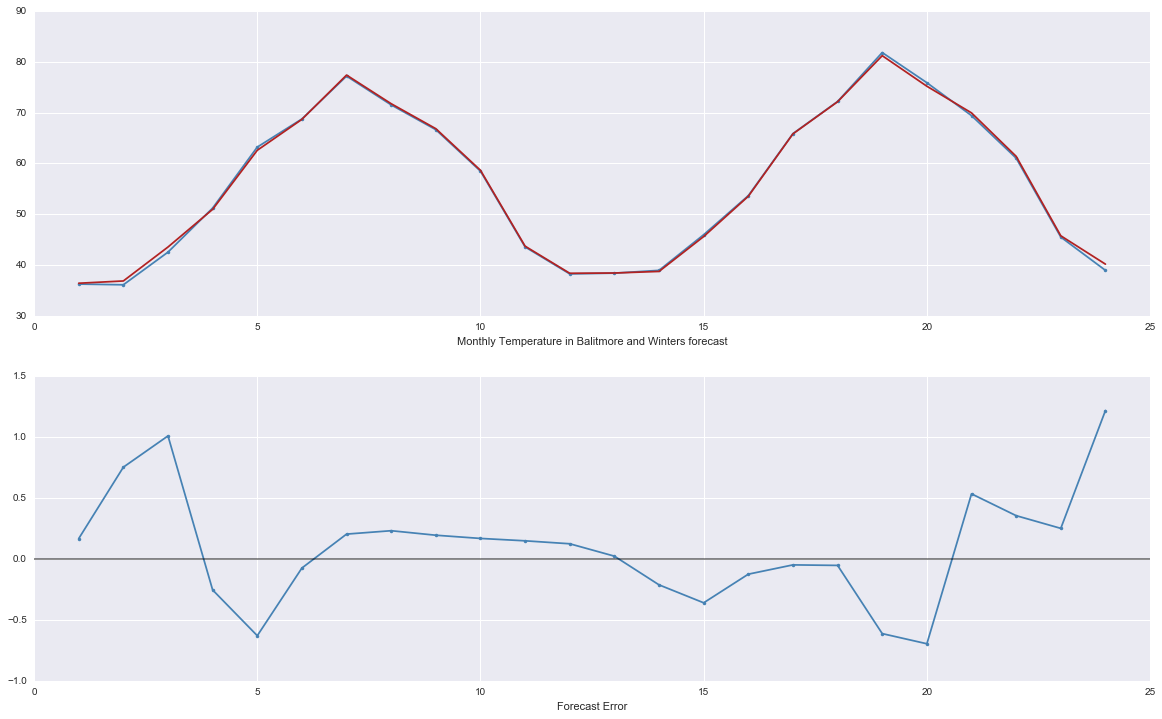

In [14]:
winters, levels, trends, factors = holt_winters_forecast(52.9304, 0.2274, results[0][0], results[0][1], results[0][2], df["temperature"], initial_seasonal_factors)
figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["month"], df["temperature"], color="steelblue", marker=".")
axes.plot( df["month"], winters, color="firebrick")
axes.set_xlabel( "Monthly Temperature in Balitmore and Winters forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["month"], winters - df["temperature"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel("Forecast Error")

plt.show()